In [1]:
import numpy as np
import pandas as pd

import os
import glob

In [12]:
#plotting things

#%matplotlib qt5 -- I don't know what this is
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from cycler import cycler


#All of Anandh's customized seaborn/matplotlib settings

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

#%config InlineBackend.figure_f.ormats=['svg']

mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#mpl.rc('text', usetex=False)
#mpl.rc('text.latex', preamble=r'\usepackage{helvet}
#\renewcommand\familydefault{\sfdefault}\usepackage{sansmath}\sansmath')

    #If you want to use a different font
# mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 
#                  'serif': ['Helvetica']})

tw = 1.5
sns.set_style({"xtick.major.size": 3, "ytick.major.size": 3,
               "xtick.minor.size": 2, "ytick.minor.size": 2,
               'axes.labelsize': 16, 'axes.titlesize': 16,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', linewidth=1.5)
mpl.rc('legend', fontsize=14)
mpl.rc('figure', figsize=(9,8))

## Get data

In [13]:
directory = 'C:/Users/geeze/Desktop/'

filename = '20190823 a=b ham dil2.xlsx'

In [3]:
directory = 'Z:/Reed/Projects/micro_consortia/DARPA_biocon/Task 1.1/A=B/20190808 a=b ham dil1/'

filename = '1908071758 a=b ham dil 1.xlsx'

In [15]:
dd = pd.read_excel(directory + filename, sheet_name=None)

dd.keys()

odict_keys(['OD700', 'CFP60', 'CFP100', 'YFP60', 'YFP100', 'OD700_tidy', 'CFP60_tidy', 'CFP100_tidy', 'YFP60_tidy', 'YFP100_tidy', 'all_tidy', 'IDs', 'Exp'])

## Create condensed data

In [5]:
def join_fluor_and_od700 (dict_of_data):
    
    #get the data sheets you want to join
    useful_sheets = [x for x in dd.keys() if '_tidy' in x]

    #find the od sheet, which will be the master one
    od_sheet = [x for x in useful_sheets if 'OD700' in x]

    #get the others using od_sheet
    others = [x for x in useful_sheets if x not in od_sheet]
    
    #now that od_sheet is used, pop the value out of the list
    if len(od_sheet) == 1:
        od_sheet = od_sheet[0]
    else:
        raise ValueError("looking for the od_sheet with 'OD700' found more than one data sheet")

    
    #get the od time column
    ot = np.sort(np.unique(dict_of_data[od_sheet]['Time']))
    
    #rename od stuff
    dict_of_data[od_sheet] = dict_of_data[od_sheet].rename({'value' : od_sheet.lower().replace('_tidy', '')}, axis='columns')
    
    #for the remaining sheets of data you want to join
    for sheet in others:
        #get this one's time values
        ft = np.sort(np.unique(dict_of_data[sheet]['Time']))
        
        #create dict to identify fluor time column entries with od time columns entries
        #every time you see time (fluor time entry), replace it with (od time entry)
        time_replacement_dict = {x : y for x,y in zip(ft,ot)}
    
        #replace the time identifier column in the fluor df
        dict_of_data[sheet]['Time'] = dict_of_data[sheet]['Time'].map(time_replacement_dict)
        
        #do some renaming
        dict_of_data[sheet] = dict_of_data[sheet].rename({'value' : sheet.lower().replace('_tidy', '')}, axis='columns')
    

    #load all data for joining
    dataframes = [dict_of_data[sheet] for sheet in useful_sheets]
    
    all_data_joined = pd.concat(dataframes, axis='columns')
    
    all_data_joined = all_data_joined.loc[:,~all_data_joined.columns.duplicated()]
    
    #fix overflow errors
    all_data_joined = all_data_joined.replace("OVRFLW", 99999)
    
    return all_data_joined

In [6]:
dense = join_fluor_and_od700(dd)

In [7]:
dense.to_csv(directory + 'dense.csv', index=False)

## Create od normalized fluorescence

In [8]:
fluor_cols = [x for x in dense.columns if 'fp' in x]

In [9]:
fluor_cols

['cfp60', 'cfp100', 'yfp60', 'yfp100']

In [10]:
#create od normalized fluor data

dense_n = dense.copy()

new_cols = [x + '_norm' for x in fluor_cols]

odnormdata = [(dense_n[x]/dense_n['od700']) for x in fluor_cols]

for title,data in zip(new_cols, odnormdata):
    dense_n[title] = data

In [11]:
dense_n.to_csv(directory + 'dense_odnorm.csv', index=False)

## Create trace over many dilutions

In [16]:
df = dd['all_tidy']

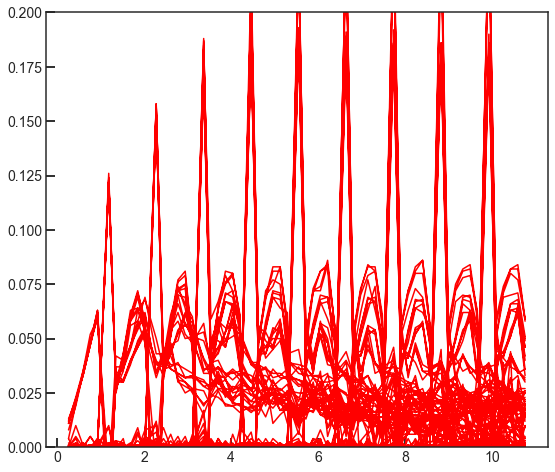

In [18]:
plt.plot(df['Time'], df['od700'].diff())
plt.ylim([0, 0.2])
#from the plot, we can see that all dilution events cause od700 spikes that exceed 0.125 (choose value), which
#are more than any background changes due to growth or noise. If we look for places where the differences exceed
#this value, we should be able to extract all the places where a new growth curve should start


xx = df['od700'].diff()
i = xx > 0.115

In [19]:
#these should be the first time points after dilutions
dil_t = df.loc[i, 'Time'].unique()
#update this to include t=0 which is the start time for dil 0
dil_t = np.insert(dil_t, 0, 0)
#add final time point to make later iteration steps that look between ranges of data easier
dil_t = np.append(dil_t, max(df['Time']))

#create the list of dils too
dils = df['dil'].unique()


dil_to_t = {d:t for d, t in zip(dils, dil_t)}

In [20]:
dil_to_t

{0: 0.0,
 1: 1.18583333333333,
 2: 2.2775,
 3: 3.36916666666666,
 4: 4.46083333333333,
 5: 5.5525,
 6: 6.64444444444444,
 7: 7.73638888888888,
 8: 8.82833333333333,
 9: 9.92611111111111,
 'nodata': 10.7594444444444}

In [21]:
dil_to_t.pop('nodata')

10.7594444444444

In [23]:
###Working on concatenating all the sliced 1 hour growth sections into a continuous data set by adding concat
#statements to the loop below

sections = []

for d in dil_to_t:
    if d == max(dils):
        high_time = max(df['Time'])
    else:
        high_time = dil_to_t[d+1]
    
    take = df.loc[(df['dil'] == d) & (df['Time'] >= dil_to_t[d]) & (df['Time'] < high_time)]
    
    sections.append(take)

TypeError: '>' not supported between instances of 'str' and 'int'

In [25]:
trace_data = pd.concat(sections)

In [28]:
# trace_data.to_csv('dil_trace_tidy.csv')

## Create cumulative fluorescence (generally not a good idea when just tracking A:B ratio)

### probably skip this unless you have a good reason not to

#### there is a possible error in here, I think this might be overwriting the OD normed fluor columns

In [103]:
def cumsum_fluor (df):
    """
    create cumulative summed fluor data for fluorescence and od normalized fluorescence, append it to big datasheet
    """
    
    #get the columns you want to sum
    sum_these = [x for x in df.columns if 'fp' in x] #works only if target columns are unique in containing 'fp'
    
    #start with the orig df in the list so you can just give the final list to pd.concat
    add_these = []
    for well in np.unique(df['well']):

        i = df['well'] == well

        #sort values by time so you get the cum sum of the values in the correct time order
        sums = df.loc[i].sort_values('Time').loc[:, sum_these].cumsum()

        sums.columns = sums.columns + '_sum'
        
        add_these.append(sums)
    
    sums_together = pd.concat(add_these, axis='index')
    
    df_plus_sums = pd.concat([df, sums_together], axis='columns')
    
    return df_plus_sums

In [104]:
dense_n_sum = cumsum_fluor(dense_n)

['cfp', 'yfp', 'cfp_norm', 'yfp_norm']


In [107]:
dense_n_sum.to_csv(directory + 'condensed_normed_cumsum_data.csv')

## create a 2 stage CFP YFP trace recentered at dil

### before you do this, you have to go into the data sheet and manually (with a simple if statement) add the dilution number in excel. Find where OD drops significantly (you should generally know where to find this since you did the experiment) and set up an if statement to put dil = 0 in times below this and dil=1 in times above

In [448]:
#already had the above analysis done
df = dd['dense_odnorm_tidy'].copy()

In [449]:
#needs to contain 'dil'
df.columns

Index(['Time', 'Temp C', 'dil', 'well', 'od700', 'iptg', 'sal', 'a', 'b',
       'cfp', 'yfp', 'cfp_norm', 'yfp_norm'],
      dtype='object')

In [450]:
def recenter_at_dil (dense_data):
    """
    recenters the fluorescence data at the first dilution of a plate, only supports one dilution.
    
    Initial growth phase is the 0th dilution, then first dilution is the only dilution
    
    ---Params---
    
    dense_data : a dataframe in which all the different measurement modalities (YFP, OD, CFP)
                    with differing time indices have been condensed into this sheet which has one single
                    time index
    """
    
    df = dense_data.copy()
    
    
    #I only want to do this recentering on raw and normalized fluor, not summed stuff
    just_fp = [x for x in df.columns if 'fp' in x]
    fp_not_sum = [x for x in just_fp if '_sum' not in x]
    recntr_cols = [x + '_recntr' for x in fp_not_sum]
    
    #preallocate these columns to fill
    for col in recntr_cols:
        df[col] = np.nan
        
    
    #gotta loop over all the wells
    for well in np.unique(df['well']):
        
        iwell = df['well'] == well

        #this is where the function restricts its support to just one dilution
        idil = df['dil'] == 0
        
        ### 0th dil ###
        #get last time value in 0th dil
        max_time = max(df.loc[iwell & idil, 'Time'])

        imaxtime = df['Time'] == max_time

        #get values at that time
        last_time_data = df.loc[iwell & idil & imaxtime]

        ### 1st dil ###
        #get first time value in 1st dil
        min_time = min(df.loc[iwell & ~idil, 'Time'])
                                        #note the NOT operator here to get the 1st dil

        imintime = df['Time'] == min_time

        #get values at that time too
        first_time_data = df.loc[iwell & ~idil & imintime]

        
        ###get values to subtract from all values in the first dil
        
        #gotta reset the index because subtraction of dataframes will only work when BOTH index and columns are matched up
        sub_from_first = (first_time_data.loc[:,fp_not_sum].reset_index(drop=True)
                          - last_time_data.loc[:,fp_not_sum].reset_index(drop=True))

        #do the subtraction, has to be done column-wise because dataframe subtraction is very particular and lame
        #and will only accept index-less scalars from the .values at the end there.
        for recntr_col, col in zip(recntr_cols, fp_not_sum):
            #just modifying the entries in the 1st dilution to center them on the last values of the 0th dil
            new_info = df.loc[iwell & ~idil, col] - sub_from_first.loc[:, col].values
            df.loc[iwell & ~idil, recntr_col] = new_info
            
            #backfilling the 0th dilution values in the recentered data with
            #a copy of the original values (they don't change)
            df.loc[iwell & idil, recntr_col] = df.loc[iwell & idil, col]
            
            
    return df

In [451]:
dense_norm_sum_recntr = recenter_at_dil(df)

In [452]:
dense_norm_sum_recntr.to_csv(directory + 'dense_normed_recentered_tidy.csv')

## calculate fraction of total fluor that is one fluor or another

In [470]:
def nearest_neigbors (target, target_type, search_df):
    
    #split the dataset into greater and less than
    above = search_df[target_type] >= target
    below = search_df[target_type] <= target
    
    grouped_inds = {'ab' : above, 'bel' : below}
    
    #checks for any indices that are all false, indicating that above or below is empty,
    #just saves the ones that have some values
    neighbor_inds = {key : grouped_inds[key] for key in grouped_inds if any(grouped_inds[key])}
    
    #find the nearest neighbor values in the split sets
    neighbor_vals = []
    for key in neighbor_inds:
        if key == 'ab':
            neighbor_vals.append(min(search_df.loc[neighbor_inds[key], target_type]))
            
        elif key == 'bel':
            neighbor_vals.append(max(search_df.loc[neighbor_inds[key], target_type]))
            
        else:
            raise ValueError('the keys accessing the indices of the nearest neighbors to the search value are not expected')


    #get all the indices for the nearest neighbors values in the control datas so you can get all their data,
    #they may be the same in an exact match due to the "or equal" logic above
    indices_of_neighbors = []
    for value in neighbor_vals:
        indices_of_neighbors.append(search_df[target_type] == value)
    
    #get ALL the data of the nearest neighbors using the nearest neighbor indices created just previously
    composite_data_for_neighbors = []
    for index in indices_of_neighbors:
        composite_data_for_neighbors.append(search_df.loc[index])
    

    ctrl_neigh_for_exp_value = pd.concat(composite_data_for_neighbors, axis='index')
    
    return ctrl_neigh_for_exp_value

In [471]:
def nearest_by_well (target_od, target_type, search_df):
    
    wells = np.unique(search_df['well'])
    
    nearest = []
    for well in wells:
        
        this_well_ctrl_data = search_df.loc[search_df['well'] == well]
        
        nearest.append(nearest_neigbors(target_od, target_type, search_df))
        
    neighs_by_well = pd.concat(nearest, axis='index')
    
    return neighs_by_well

In [472]:
def calc_frac (time, exp_well_data, dict_of_ctrl_datas, fluor_str_list):
    
    """
    searches each unique well of control monoculture data within a time window for a 
    target OD700 value taken from an experimental growth curve.
    
    Then takes fluorescence values associated with those control cultures OD700
    and compares experimental fluorescence to control fluorescence to estimate
    population fraction
    
    
    time = the time point in the experimental dataset you are using
    
    exp_well_data = a dataframe of all the time course data taken from the experimental well, contains od, fluorescences
                    and some processed data like fluor/OD and such
                    
    dict_of_ctrl_datas = a dictionary with keys ['a', 'b'] and values that are all the control monoculture replicate well
                        data that have either monoculture a cells (key 'a') or b cells (key 'b'). There can be multiple
                        replicate wells in these data
                        
    fluor_str_list = the type of fluorescence data you want to use to calculate fractions. probably either
                    ['cfp', 'yfp'] (order is important, cfp goes with a data, yfp goes with b) or normalized
                    ['cfp_norm', 'yfp_norm']
    
    """
    
    #extract target_od from the experimental well data
    i = exp_well_data['Time'] == time
    target_od = exp_well_data.loc[i, 'od700'].values[0]
    
    
    #get nearest neighbors in only a_data and only b_data, but do so for each unique well in each of those
    #control monoculture sets
    nearest = [nearest_by_well(target_od, 'od700', dict_of_ctrl_datas[key]) for key in dict_of_ctrl_datas]

    #control neighbor fluor means
    mean_ctrl_fluor_val_at_od = {fluor : np.mean(near[fluor]) for near, fluor in zip(nearest, fluor_str_list)}

    #compare the exp fluorescences to the identified control fluor means just calculated
    exp_fluor_vals_at_od = exp_well_data.loc[exp_well_data['Time'] == time, fluor_str_list]

    fracs_of_ctrl_fluor = {fluor : (exp_fluor_vals_at_od[fluor] / mean_ctrl_fluor_val_at_od[fluor]) for fluor in fluor_str_list}

    fracs_df = pd.DataFrame.from_dict(fracs_of_ctrl_fluor).rename(columns=lambda x: x+'_expctrl_frac')
    
    return fracs_df

In [473]:
def df_frac_by_fluor (df_full, indices_list, ids, well_id_info_cols, fluor_data_str_list):

    """
    takes a full dataframe of biotek data that has mixed experimental cultures and control monocultures in identical setup
    environments and adds columns to the dataframe that are the estimates of population fraction by the chosen fluorescence
    data

    indices_list = [indices of mixed cultures, indices of A only controls, indices of B only controls]

    """
    #unpack indices
    mix, i_a, i_b = indices_list
    
    #instantiate the columns to hold the calculated fraction data
    for fluor in fluor_data_str_list:
        df_full[fluor + '_expctrl_frac'] = np.nan

    #just iterate on the mixed wells, since these are the only ones you want to calc for
    for well in np.unique(df_full.loc[mix, 'well']):

        for dil in np.unique(df_full.loc[mix, 'dil']):

                ### experimental data
            #exp data indices
            iwell = df_full['well'] == well

            #dil indices
            idil = df_full['dil'] == dil

            #get all the exp data
            well_data = df_full.loc[iwell & idil]


                ### control monoculture data
            #id info indices
            idwell = ids['well'] == well

            #get the identifying inducer information so you know what control cultures to compare this well to
            id_info = ids.loc[idwell]

            #get the control culture data for the appropriate id information (inducer conditions and cell types)
                #creating the indices for the identifying well info
                #NOTE: YOU NEED TO SEARCH FOR THE INFORMATION INSIDE OF DF_FULL BECAUSE CTRLS AREN'T IN THE MIX WELLS
            a_cell, b_cell, iptg, sal = [df_full[info] == id_info[info].values[0] for info in ['a', 'b', 'iptg', 'sal']]


            #find the indices for the appropriate control culture at the experimental well's inducer information
            crrct_a_ctrl_idx = i_a & a_cell & iptg & sal
            crrct_b_ctrl_idx = i_b & b_cell & iptg & sal

        
            #get control culture data
            a_data = df_full.loc[crrct_a_ctrl_idx & (df_full['dil'] == dil)]
            b_data = df_full.loc[crrct_b_ctrl_idx & (df_full['dil'] == dil)]

            ctrl_culture_datas = {'a' : a_data, 'b' : b_data}

                ### now that all appropriate data is selected, do the calculations

            all_frac_calcs_list = []
            times = np.unique(well_data['Time'])
            t_max = max(times)

            for time in times: 

                #create time window, this code is ugly as hell, should create a time:time window dict outside the loop
                wid = 0.5
                time_window = [(t-wid, t+wid) if (t-wid)>=0 else (0, t+wid) for t in [time]]
                #because i think it makes cleaner comprehensions
                time_window = [(t[0], t[1]) if (t[1]+wid)<=t_max else (t[0]-wid, t_max) for t in time_window][0]

                #window the control data
                l_t = time_window[0]
                u_t = time_window[1]

                windowed_ctrl_datas = {key : (ctrl_culture_datas[key].loc[(ctrl_culture_datas[key]['Time'] >= l_t) & (ctrl_culture_datas[key]['Time'] <= u_t)])
                                       for key in ctrl_culture_datas}

                #add the caculation
                all_frac_calcs_list.append(calc_frac(time, well_data, windowed_ctrl_datas, fluor_data_str_list))


            all_frac_calcs = pd.concat(all_frac_calcs_list, axis='index').sort_index()

            #concat the newly calculated fractions to the full dataframe of data by column
            #will hopefully just fill in the columns as more concats are done
            df_full.loc[all_frac_calcs.index, all_frac_calcs.columns] = all_frac_calcs


    return df_full

In [476]:
#df
df = dd['dense_norm_rcntr_normfrac'].copy()

#ids
ids = dd['IDs'].copy()

#well_id_info_cols, all the unique pieces of info you need to find the control wells with matching
#experimental conditions to a target experimental well
well_info_cols = ['a', 'b', 'iptg', 'sal']

#which fluorescence data you want to use
fluors = ['cfp', 'yfp']
norm_fluors = ['cfp_norm', 'yfp_norm']

In [477]:
#indices

#all wells with just B (YFP)
i_b = df['a'] == 'x'

#all wells with just A (CFP)
i_a = df['b'] == 'x'

#all empty wells with just media
lb = df['a'] == 'lb'

#all wells with control GFP expressing cells in them
ctrl = df['a'] == 'ctrl'

#zeroth dilution
zero = df['dil'] == 0

#all that are mixed cultures
mix = ~i_a & ~i_b & ~lb & ~ctrl

In [478]:
#package the relevant indices

rel_indices = [mix, i_a, i_b]

In [479]:
output = df_frac_by_fluor (df, rel_indices, ids, well_info_cols, fluors)

In [480]:
output.to_csv(directory + 'dense_norm_rcntr_expctrl_frac.csv')

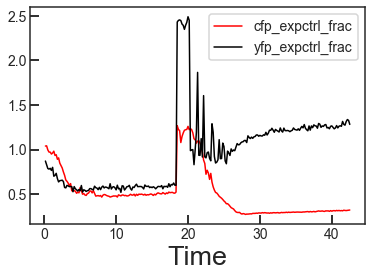

In [394]:
#tested well A1, the fractions seem to indicate that culture ends up looking like ctrl only B(yfp) cells
#checked the raw cfp and yfp values and this confirms it. A1 cfp value is much lower than ctrl A only cfp
#A1 yfp is very close to ctrl B only yfp value

# output.loc[output['well'] == 'A1'].plot(x='Time', y=['cfp_expctrl_frac', 'yfp_expctrl_frac'])